<a href="https://colab.research.google.com/github/ggmeiner22/Camera-Calibration-with-Gradio-UI/blob/main/Camera_Calibration_with_Gradio_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Camera Calibration (OpenCV + Gradio UI)
## In this project, I will calibrate my own camera using OpenCV’s calibration tools.

### The goal is to compute my camera’s intrinsic parameters (focal length, principal point, distortion coefficients).

### I will also build a small Gradio user interface (UI) to streamline the calibration process, visualize results, and demonstrate understanding of camera geometry.



In [1]:
%pip -q install opencv-python-headless numpy gradio plotly pytransform3d==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Add imports:

In [2]:
import os, json, glob, io, base64, math, textwrap, random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
import cv2 as cv
import gradio as gr
import plotly.graph_objects as go
from pytransform3d.transformations import plot_transform

1) Collect Calibration Images

Save the image into /content/pattern.png

In [4]:
# Download the OpenCV checkerboard pattern
import urllib.request

url = "https://docs.opencv.org/4.x/pattern.png"
save_path = "/content/pattern.png"

urllib.request.urlretrieve(url, save_path)
print(f"Saved checkerboard to {save_path}")

Saved checkerboard to /content/pattern.png


Print the OpenCV chessboard calibration pattern: pattern.png.

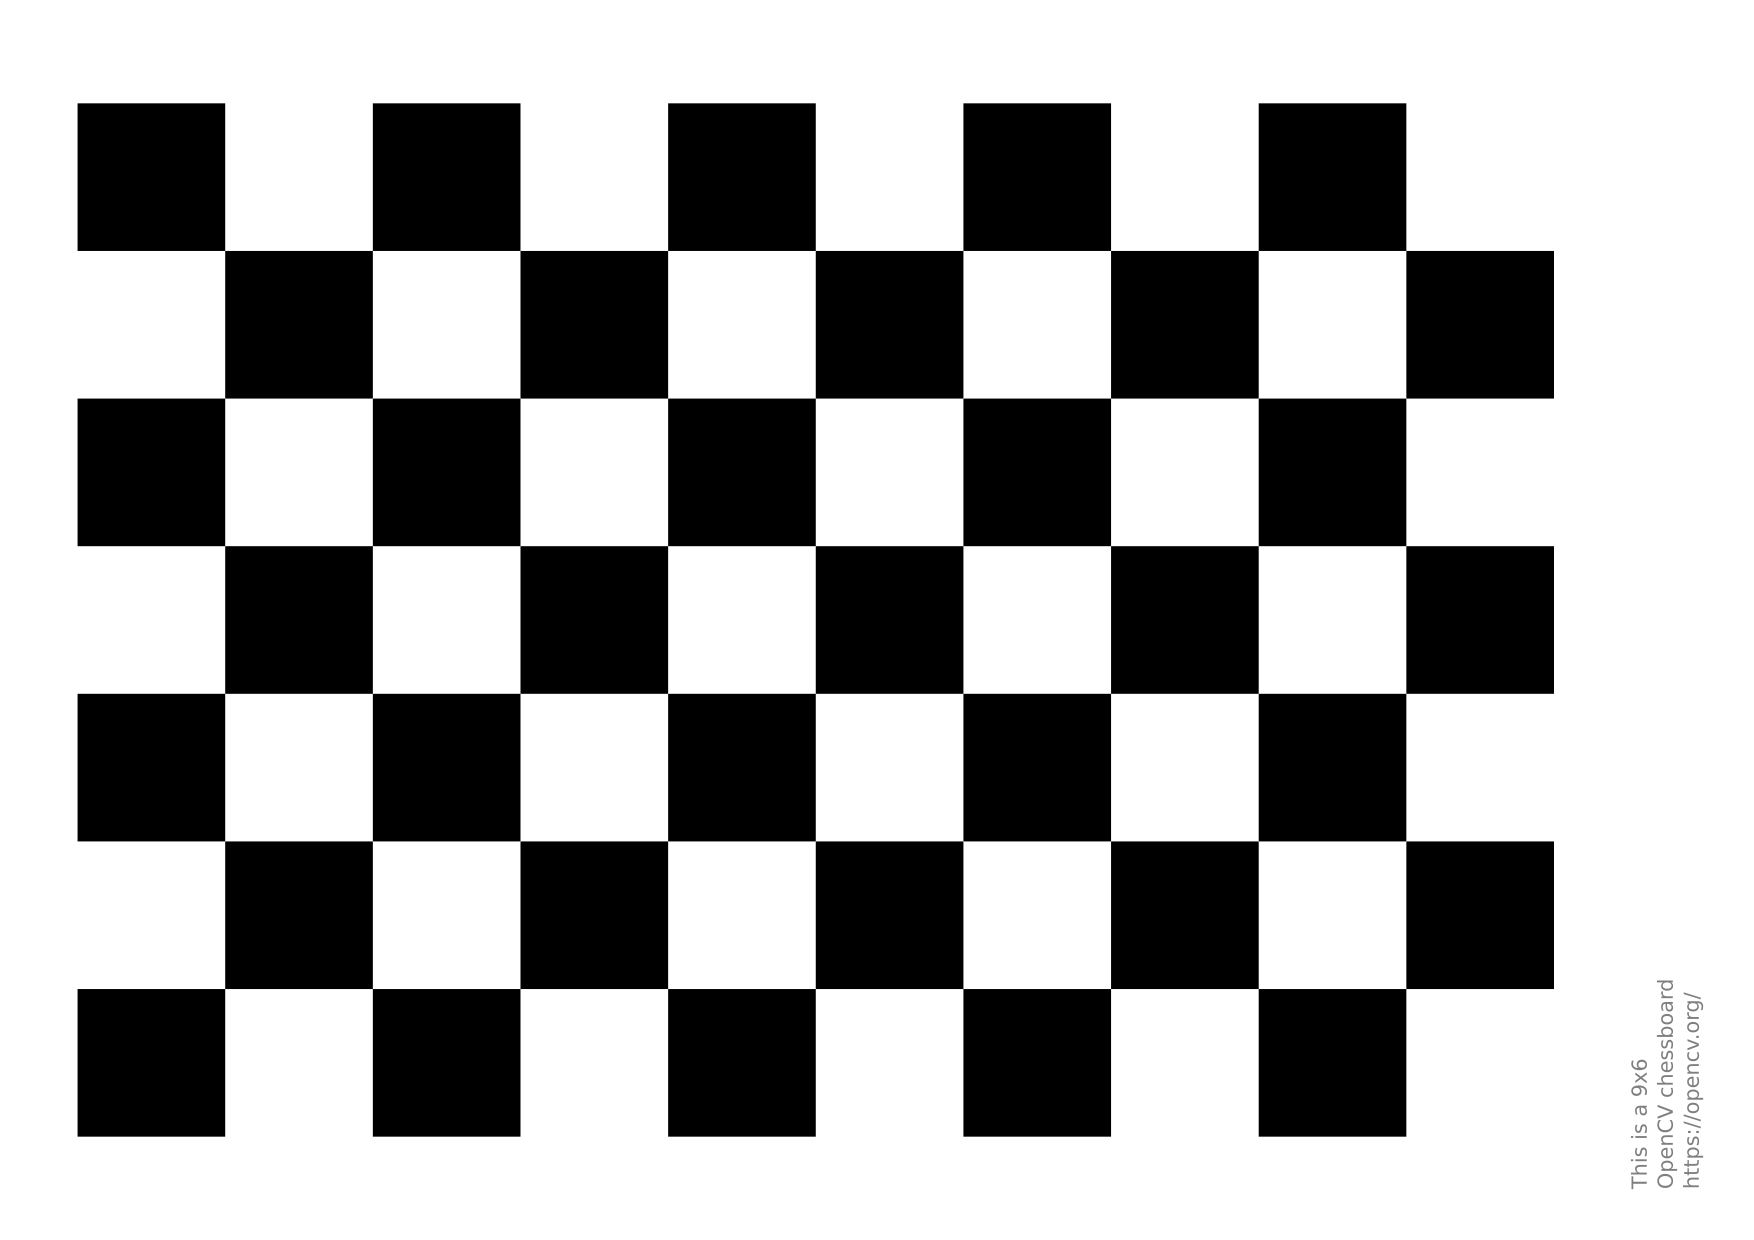

In [5]:
from IPython.display import Image, display
display(Image(filename=save_path))

I/O class

In [6]:
class IO:
    @staticmethod
    def ensure_dir(path: str):
        os.makedirs(path, exist_ok=True)

    @staticmethod
    def list_images(folder: str, exts=(".jpg",".jpeg",".png",".bmp")) -> List[str]:
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(folder, f"*{e}")))
        return sorted(files)

    @staticmethod
    def save_json(obj: Dict[str, Any], path: str):
        with open(path, "w") as f:
            json.dump(obj, f, indent=2)

    @staticmethod
    def load_json(path: str) -> Dict[str, Any]:
        with open(path, "r") as f:
            return json.load(f)

    @staticmethod
    def imread_rgb(path: str) -> np.ndarray:
        bgr = cv.imread(path, cv.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(path)
        return cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

    @staticmethod
    def imwrite_rgb(path: str, rgb: np.ndarray):
        bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
        cv.imwrite(path, bgr)

In [7]:
class Board:
    """Chessboard model (pattern_size uses inner corners)."""
    @staticmethod
    def object_points(pattern_size: Tuple[int,int], square_size_m: float) -> np.ndarray:
        cols, rows = pattern_size
        objp = np.zeros((rows*cols, 3), np.float32)
        xs, ys = np.meshgrid(np.arange(cols), np.arange(rows))
        objp[:, :2] = np.vstack([xs.ravel(), ys.ravel()]).T * square_size_m
        return objp

    @staticmethod
    def pattern_tuple(cols: int, rows: int) -> Tuple[int,int]:
        return (cols, rows)

In [8]:
class Img:
    @staticmethod
    def draw_axes(rgb: np.ndarray, K: np.ndarray, D: np.ndarray, rvec: np.ndarray, tvec: np.ndarray, axis_len: float) -> np.ndarray:
        img = rgb.copy()
        axis_3d = np.float32([
            [0, 0, 0],
            [axis_len, 0, 0],
            [0, axis_len, 0],
            [0, 0, -axis_len]
        ])
        axis_2d, _ = cv.projectPoints(axis_3d, rvec, tvec, K, D)
        axis_2d = axis_2d.reshape(-1, 2).astype(int)
        o, x, y, z = map(tuple, axis_2d)
        cv.line(img, o, x, (255,0,0),   3)  # X red
        cv.line(img, o, y, (0,255,0),   3)  # Y green
        cv.line(img, o, z, (0,0,255),   3)  # Z blue
        return img

    @staticmethod
    def put_text(img: np.ndarray, text: str, org=(10,30)):
        out = img.copy()
        cv.putText(out, text, org, cv.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), 2, cv.LINE_AA)
        return out

In [9]:
class Cam:
    @staticmethod
    def rodrigues_to_R(rvec: np.ndarray) -> np.ndarray:
        R, _ = cv.Rodrigues(rvec)
        return R

    @staticmethod
    def camera_center_in_board(rvec: np.ndarray, tvec: np.ndarray) -> np.ndarray:
        # X_c = R X_w + t  ->  C_w = -R^T t
        R = Cam.rodrigues_to_R(rvec)
        C = -R.T @ tvec.reshape(3,1)
        return C.flatten()

    @staticmethod
    def to_jsonable(mat: np.ndarray) -> List[List[float]]:
        return mat.tolist()

In [10]:
class Calib:
    @staticmethod
    def detect_corners(image_paths: List[str], pattern_size: Tuple[int,int]):
        objp_unit = Board.object_points(pattern_size, square_size_m=1.0)  # scale later
        objpoints, imgpoints = [], []
        img_size = None

        for p in image_paths:
            bgr = cv.imread(p, cv.IMREAD_COLOR)
            if bgr is None:
                print(f"[WARN] Could not read image: {p}")
                continue
            gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
            if img_size is None:
                img_size = (gray.shape[1], gray.shape[0])
            ret, corners = cv.findChessboardCorners(gray, pattern_size,
                                                    flags=cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE)
            if ret:
                corners_ref = cv.cornerSubPix(
                    gray, corners, (11,11), (-1,-1),
                    (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                )
                objpoints.append(objp_unit.copy())
                imgpoints.append(corners_ref)
            else:
                print(f"[INFO] Chessboard not found: {os.path.basename(p)}")

        return objpoints, imgpoints, img_size

    @staticmethod
    def calibrate(objpoints_unit, imgpoints, img_size, square_size_m: float):
        if img_size is None or len(objpoints_unit) == 0:
            raise ValueError("No valid detections or unknown image size.")
        scaled_objpoints = [op * square_size_m for op in objpoints_unit]

        ret, K, D, rvecs, tvecs = cv.calibrateCamera(
            scaled_objpoints, imgpoints, img_size, None, None, flags=cv.CALIB_RATIONAL_MODEL
        )
        return {
            "rms_reprojection_error": float(ret),
            "K": K, "D": D, "rvecs": rvecs, "tvecs": tvecs, "image_size": img_size
        }

    @staticmethod
    def undistort_preview(rgb: np.ndarray, K: np.ndarray, D: np.ndarray):
        h, w = rgb.shape[:2]
        newK, _ = cv.getOptimalNewCameraMatrix(K, D, (w, h), 1.0, (w, h))
        und = cv.undistort(cv.cvtColor(rgb, cv.COLOR_RGB2BGR), K, D, None, newK)
        return rgb, cv.cvtColor(und, cv.COLOR_BGR2RGB)

    @staticmethod
    def save_calibration_json(path: str, calib: Dict[str, Any]):
        out = {
            "rms_reprojection_error": calib["rms_reprojection_error"],
            "K": Cam.to_jsonable(calib["K"]),
            "D": Cam.to_jsonable(calib["D"]),
            "rvecs": [rv.flatten().tolist() for rv in calib["rvecs"]],
            "tvecs": [tv.flatten().tolist() for tv in calib["tvecs"]],
            "image_width": int(calib["image_size"][0]),
            "image_height": int(calib["image_size"][1]),
        }
        IO.save_json(out, path)

    @staticmethod
    def estimate_poses(image_paths, pattern_size, square_size_m, K, D, imgpoints):
        objp = Board.object_points(pattern_size, square_size_m)
        results = []
        for pth, corners in zip(image_paths, imgpoints):
            ok, rvec, tvec = cv.solvePnP(objp, corners, K, D, flags=cv.SOLVEPNP_ITERATIVE)
            if ok:
                results.append((pth, rvec, tvec))
        return results